# Poutyne's Tips and Tricks

Poutyne offers a variety of tools for fine-tuning the information generated during the training, such as colouring the training update message, a progress bar, multi-GPUs, user callbacks interface and a user naming interface for the metrics' names. 

Let's install the latest version of Poutyne and colorama (if they are not already), and import all the needed packages.

In [1]:
%pip install --upgrade poutyne
%pip install --upgrade colorama
%matplotlib inline
import os
import math
import shutil

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from torchvision import transforms, utils
from torchvision.datasets.mnist import MNIST

from poutyne import set_seeds, Model, ModelCheckpoint, CSVLogger, Callback, Experiment, SKLearnMetrics, plot_history

## Hyperparameters, Dataset and Network

In this section, we setup the hyperparameters, dataset and network we will use throughout these tips and tricks. 

### Training Constants

Now, let's set our training constants. We first have the CUDA device used for training if one is present. Second, we set the `train_split` to 0.8 (80%) to use 80% of the dataset for training and 20% for testing the trained model. Third, we set the number of classes (i.e. one for each digit). Finally, we set the batch size (i.e. the number of elements to see before updating the model), the learning rate for the optimizer, and the number of epochs (i.e. the number of times we see the full dataset).

In [2]:
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")

train_split_percent = 0.8

num_classes = 10

batch_size = 32
learning_rate = 0.1
num_epochs = 5

In Poutyne, as we will see in the following sections, you can define your own loss functions and optimizers. However, we can also pass magic strings to use PyTorch's standard optimizers and loss functions. Furthermore, for the optimizer, we can also use a dictionary to set other parameters as the learning rate, for instance, if we don't want the default learning rate.

Here, we initialize the dictionary for our optimizer as well as the string for our loss function. We thus use SGD with the specified learning rate and the cross-entropy loss.

In [3]:
optimizer = dict(optim='sgd', lr=learning_rate)  # Could be 'sgd' if we didn't need to change the learning rate.
loss_function = 'cross_entropy'

### Loading the Dataset

The following code helps load the MNIST dataset and creates the PyTorch DataLoaders that split our datasets into batches. Then, the train DataLoader shuffles the examples of the training dataset to draw the examples without replacement.

In [4]:
full_train_dataset = MNIST('./datasets', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('./datasets', train=False, download=True, transform=transforms.ToTensor())

num_data = len(full_train_dataset)
train_length = int(math.floor(train_split_percent * num_data))
valid_length = num_data - train_length

train_dataset, valid_dataset = random_split(
    full_train_dataset,
    [train_length, valid_length],
    generator=torch.Generator().manual_seed(42),
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

In [5]:
len(train_dataset), len(valid_dataset)

(48000, 12000)

### Initializing the Network

We create a fonction to initialize a simple convolutional neural network.

In [6]:
def create_network():
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(32 * 7 * 7, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, num_classes),
    )

## Vanilla Usage

The following code trains our network in the simplest way possible with Poutyne. We use the accuracy metric so that we can see the performance during training.

In [7]:
# Instantiating our network
network = create_network()

# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    loss_function,
    batch_metrics=['accuracy'],
    device=device,
)

# Train
history = model.fit_generator(train_loader, valid_loader, epochs=num_epochs)

# Test
test_loss, test_acc = model.evaluate_generator(test_loader)

Epoch: 1/5 Train steps: 1500 Val steps: 375 6.46s loss: 0.365703 acc: 88.227083 val_loss: 0.085653 val_acc: 97.475000
Epoch: 2/5 Train steps: 1500 Val steps: 375 6.31s loss: 0.128519 acc: 96.035417 val_loss: 0.064274 val_acc: 98.091667
Epoch: 3/5 Train steps: 1500 Val steps: 375 6.19s loss: 0.097421 acc: 97.050000 val_loss: 0.049929 val_acc: 98.583333
Epoch: 4/5 Train steps: 1500 Val steps: 375 6.26s loss: 0.081124 acc: 97.520833 val_loss: 0.052656 val_acc: 98.400000
Epoch: 5/5 Train steps: 1500 Val steps: 375 6.22s loss: 0.076987 acc: 97.670833 val_loss: 0.042191 val_acc: 98.658333
Test steps: 313 0.81s test_loss: 0.033052 test_acc: 98.940000                                                   


## Plotting Training

The training methods in Poutyne returns a list of dictionaries containing the metrics output during training. Using Poutyne, it is then possible to plot this training history.

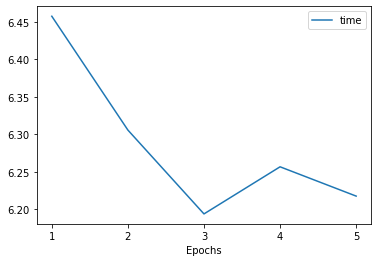

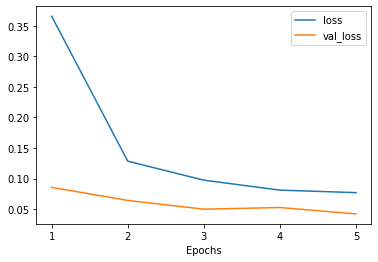

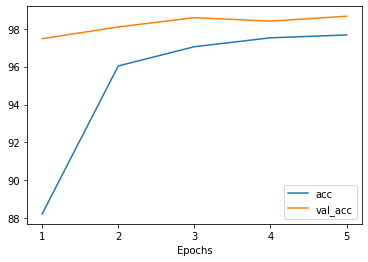

In [8]:
_ = plot_history(history)

It is also possible to restrict the metrics shown and to customize the plots by using custom labels and titles.

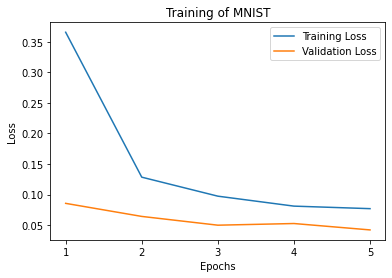

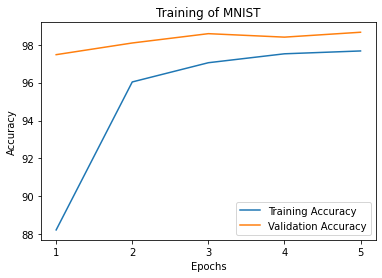

In [9]:
_ = plot_history(
    history,
    metrics=['loss', 'acc'],
    labels=['Loss', 'Accuracy'],
    titles='Training of MNIST',
)

## Initilalizing Your Optimizer and Loss Function Yourself

Instead of using magic strings for the optimizer and the loss function, it's quite easy to initialize your own and pass them to Poutyne.

In [8]:
# Instantiating our network
network = create_network()

# Instantiating our loss function and optimizer
own_optimizer = optim.SGD(network.parameters(), lr=learning_rate)
own_loss_function = nn.CrossEntropyLoss()

# Poutyne Model on GPU
model = Model(
    network,
    own_optimizer,
    own_loss_function,
    batch_metrics=['accuracy'],
    device=device,
)

# Train
model.fit_generator(train_loader, valid_loader, epochs=num_epochs)

# Test
test_loss, test_acc = model.evaluate_generator(test_loader)

Epoch: 1/5 Train steps: 1500 Val steps: 375 6.02s loss: 0.352180 acc: 88.787500 val_loss: 0.106241 val_acc: 96.541667
Epoch: 2/5 Train steps: 1500 Val steps: 375 6.06s loss: 0.130747 acc: 96.018750 val_loss: 0.061103 val_acc: 98.250000
Epoch: 3/5 Train steps: 1500 Val steps: 375 6.10s loss: 0.101365 acc: 96.920833 val_loss: 0.055351 val_acc: 98.400000
Epoch: 4/5 Train steps: 1500 Val steps: 375 6.12s loss: 0.085372 acc: 97.429167 val_loss: 0.048014 val_acc: 98.566667
Epoch: 5/5 Train steps: 1500 Val steps: 375 6.20s loss: 0.075207 acc: 97.758333 val_loss: 0.042446 val_acc: 98.725000
Test steps: 313 0.74s test_loss: 0.032898 test_acc: 98.900000                                                   


## Bypassing PyTorch DataLoaders

Above, we defined DataLoaders for our datasets. However, with Poutyne, it is not strictly necessary since it provides the [`fit_dataset`](https://poutyne.org/model.html#poutyne.Model.fit_dataset) and [`evaluate_dataset`](https://poutyne.org/model.html#poutyne.Model.evaluate_dataset) methods to which you can pass the necessary parameters such as the batch size. Under the hood, Poutyne initializes the DataLoaders for you.

In [9]:
# Instantiating our network
network = create_network()

# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    loss_function,
    batch_metrics=['accuracy'],
    device=device,
)

# Train
model.fit_dataset(
    train_dataset,
    valid_dataset,
    epochs=num_epochs,
    batch_size=batch_size,
    num_workers=2,
)

# Test
test_loss, test_acc = model.evaluate_dataset(
    test_dataset,
    batch_size=batch_size,
    num_workers=2,
)

Epoch: 1/5 Train steps: 1500 Val steps: 375 6.05s loss: 0.352229 acc: 88.495833 val_loss: 0.082042 val_acc: 97.383333
Epoch: 2/5 Train steps: 1500 Val steps: 375 6.27s loss: 0.119815 acc: 96.275000 val_loss: 0.063403 val_acc: 98.025000
Epoch: 3/5 Train steps: 1500 Val steps: 375 6.15s loss: 0.095047 acc: 97.112500 val_loss: 0.049626 val_acc: 98.450000
Epoch: 4/5 Train steps: 1500 Val steps: 375 6.05s loss: 0.080510 acc: 97.600000 val_loss: 0.050516 val_acc: 98.500000
Epoch: 5/5 Train steps: 1500 Val steps: 375 6.14s loss: 0.069013 acc: 97.877083 val_loss: 0.049061 val_acc: 98.608333
Test steps: 313 0.71s test_loss: 0.033449 test_acc: 98.940000                                                   


## Using Callbacks

One nice feature of Poutyne is [callbacks](https://poutyne.org/callbacks.html). Callbacks allow doing actions during the training of the neural network. In the following example, we use three callbacks. The first that saves the latest weights in a file to be able to continue the optimization at the end of training if more epochs are needed. The second that saves the best weights according to the performance on the validation dataset. The last that saves the displayed logs into a TSV file.

In [10]:
# Saves everything into saves/convnet_mnist
save_path = "saves/convnet_mnist"
os.makedirs(save_path, exist_ok=True)

callbacks = [
    # Save the latest weights to be able to continue the optimization at the end for more epochs.
    ModelCheckpoint(os.path.join(save_path, 'last_epoch.ckpt')),
    # Save the weights in a new file when the current model is better than all previous models.
    ModelCheckpoint(
        os.path.join(save_path, 'best_epoch_{epoch}.ckpt'),
        monitor='val_acc',
        mode='max',
        save_best_only=True,
        restore_best=True,
        verbose=True,
    ),
    # Save the losses and accuracies for each epoch in a TSV.
    CSVLogger(os.path.join(save_path, 'log.tsv'), separator='\t'),
]

In [11]:
# Instantiating our network
network = create_network()

# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    loss_function,
    batch_metrics=['accuracy'],
    device=device,
)

# Train
model.fit_generator(train_loader, valid_loader, epochs=num_epochs, callbacks=callbacks)

# Test
test_loss, test_acc = model.evaluate_generator(test_loader)

Epoch: 1/5 Train steps: 1500 Val steps: 375 5.94s loss: 0.383525 acc: 87.658333 val_loss: 0.096297 val_acc: 97.116667
Epoch 1: val_acc improved from -inf to 97.11667, saving file to saves/convnet_mnist/best_epoch_1.ckpt
Epoch: 2/5 Train steps: 1500 Val steps: 375 6.06s loss: 0.128864 acc: 96.072917 val_loss: 0.068194 val_acc: 97.925000
Epoch 2: val_acc improved from 97.11667 to 97.92500, saving file to saves/convnet_mnist/best_epoch_2.ckpt
Epoch: 3/5 Train steps: 1500 Val steps: 375 6.27s loss: 0.100207 acc: 97.066667 val_loss: 0.054465 val_acc: 98.408333
Epoch 3: val_acc improved from 97.92500 to 98.40833, saving file to saves/convnet_mnist/best_epoch_3.ckpt
Epoch: 4/5 Train steps: 1500 Val steps: 375 6.18s loss: 0.084217 acc: 97.504167 val_loss: 0.049870 val_acc: 98.491667
Epoch 4: val_acc improved from 98.40833 to 98.49167, saving file to saves/convnet_mnist/best_epoch_4.ckpt
Epoch: 5/5 Train steps: 1500 Val steps: 375 5.99s loss: 0.074849 acc: 97.731250 val_loss: 0.044819 val_acc: 

## Making Your Own Callback

While Poutyne provides a great number of [predefined callbacks](https://poutyne.org/callbacks.html), it is sometimes useful to make your own callback.

In the following example, we want to see the effect of temperature on the optimization of our neural network. To do so, we either increase or decrease the temperature during the optimization. As one can see in the result, temperature either as no effect or has a detrimental effect on the performance of the neural network. This is so because the temperature has for effect to artificially changing the learning rates. Since we have found the right learning rate, increasing or decreasing, it shows no improvement on the results.

In [12]:
class CrossEntropyLossWithTemperature(nn.Module):
    """
    This loss module is the cross-entropy loss function
    with temperature. It divides the logits by a temperature
    value before computing the cross-entropy loss.

    Args:
        initial_temperature (float): The initial value of the temperature.
    """

    def __init__(self, initial_temperature):
        super().__init__()
        self.temperature = initial_temperature
        self.celoss = nn.CrossEntropyLoss()

    def forward(self, y_pred, y_true):
        y_pred = y_pred / self.temperature
        return self.celoss(y_pred, y_true)

In [13]:
class TemperatureCallback(Callback):
    """
    This callback multiply the loss temperature with a decay before
    each batch.

    Args:
        celoss_with_temp (CrossEntropyLossWithTemperature): the loss module.
        decay (float): The value of the temperature decay.
    """

    def __init__(self, celoss_with_temp, decay):
        super().__init__()
        self.celoss_with_temp = celoss_with_temp
        self.decay = decay

    def on_train_batch_begin(self, batch, logs):
        self.celoss_with_temp.temperature *= self.decay

So our loss function will be the cross-entropy with temperature with an initial temperature of `0.1` and a temperature decay of `1.0008`.

In [14]:
custom_loss_function = CrossEntropyLossWithTemperature(0.1)
callbacks = [TemperatureCallback(custom_loss_function, 1.0008)]

Now let's test our training loop for one epoch using the accuracy as the batch metric.

In [15]:
# Instantiating our network
network = create_network()

# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    custom_loss_function,
    batch_metrics=['accuracy'],
    device=device,
)

# Train
model.fit_generator(train_loader, valid_loader, epochs=num_epochs, callbacks=callbacks)

# Test
test_loss, test_acc = model.evaluate_generator(test_loader)

Epoch: 1/5 Train steps: 1500 Val steps: 375 6.24s loss: 0.395715 acc: 87.560417 val_loss: 0.085003 val_acc: 97.516667
Epoch: 2/5 Train steps: 1500 Val steps: 375 6.26s loss: 0.133953 acc: 96.075000 val_loss: 0.075043 val_acc: 97.825000
Epoch: 3/5 Train steps: 1500 Val steps: 375 6.16s loss: 0.107138 acc: 96.885417 val_loss: 0.058533 val_acc: 98.233333
Epoch: 4/5 Train steps: 1500 Val steps: 375 6.26s loss: 0.107013 acc: 96.916667 val_loss: 0.061053 val_acc: 98.266667
Epoch: 5/5 Train steps: 1500 Val steps: 375 6.34s loss: 0.124850 acc: 96.572917 val_loss: 0.077240 val_acc: 97.975000
Test steps: 313 0.73s test_loss: 0.065244 test_acc: 98.200000                                                   


## Using Experiment

Most of the time, when using Poutyne (or even PyTorch in general), we will find ourselves in an iterative model hyperparameters finetuning loop. For efficient model search, we will usually wish to save our best performing models, their training and testing statistics and even sometimes wish to retrain an already trained model for further tuning. All of the above can be easily implemented with the flexibility of Poutyne Callbacks, but having to define and initialize each and every Callback object we wish for our model quickly feels cumbersome.

This is why Poutyne provides an [Experiment class](https://poutyne.org/experiment.html), which aims specifically at enabling quick model iteration search, while not sacrificing the quality of a single experiment - statistics logging, best models saving, etc. Experiment is actually a simple wrapper between a PyTorch network and Poutyne's core Callback objects for logging and saving. Given a working directory where to output the various logging files and a PyTorch network, the Experiment class reduces the whole training loop to a single line.

The following code uses [Poutyne's Experiment class](https://poutyne.org/experiment.html) to train a network for 5 epochs. The code is quite simpler than the code in the Poutyne Callbacks section while doing more (only a few lines). Once trained for 5 epochs, it is then possible to resume the optimization at the 5th epoch for 5 more epochs until the 10th epoch using the same function.

In [16]:
def experiment_train(network, name, epochs=5):
    """
    This function creates a Poutyne Experiment, trains the input module
    on the train loader and then tests its performance on the test loader.
    All training and testing statistics are saved, as well as best model
    checkpoints.

    Args:
        network (torch.nn.Module): The neural network to train.
        working_directory (str): The directory where to output files to save.
        epochs (int): The number of epochs. (Default: 5)
    """
    # Everything is going to be saved in ./saves/{name}.
    save_path = os.path.join('saves', name)

    # Poutyne Experiment
    expt = Experiment(
        save_path,
        network,
        optimizer=optimizer,
        task='classif',
        device=device,
    )

    # Train
    expt.train(train_loader, valid_loader, epochs=epochs)

    # Test
    expt.test(test_loader)

Let's first remove the output directory if it exists so that we start training from scratch.

In [17]:
shutil.rmtree('saves/convnet_mnist_experiment', ignore_errors=True)

Let's train for 5 epochs.

In [18]:
network = create_network()
experiment_train(network, 'convnet_mnist_experiment', epochs=5)

Epoch: 1/5 Train steps: 1500 Val steps: 375 7.58s loss: 0.379637 acc: 87.677083 fscore_micro: 0.876771 val_loss: 0.084187 val_acc: 97.358333 val_fscore_micro: 0.973583
Epoch 1: val_acc improved from -inf to 97.35833, saving file to saves/convnet_mnist_experiment/checkpoint_epoch_1.ckpt
Epoch: 2/5 Train steps: 1500 Val steps: 375 8.12s loss: 0.125676 acc: 96.160417 fscore_micro: 0.961604 val_loss: 0.060368 val_acc: 98.191667 val_fscore_micro: 0.981917
Epoch 2: val_acc improved from 97.35833 to 98.19167, saving file to saves/convnet_mnist_experiment/checkpoint_epoch_2.ckpt
Epoch: 3/5 Train steps: 1500 Val steps: 375 7.96s loss: 0.094743 acc: 97.066667 fscore_micro: 0.970667 val_loss: 0.053131 val_acc: 98.475000 val_fscore_micro: 0.984750
Epoch 3: val_acc improved from 98.19167 to 98.47500, saving file to saves/convnet_mnist_experiment/checkpoint_epoch_3.ckpt
Epoch: 4/5 Train steps: 1500 Val steps: 375 7.60s loss: 0.079384 acc: 97.604167 fscore_micro: 0.976042 val_loss: 0.049395 val_acc: 

Notice how setting `task='classif'` when instantiating `Experiment` adds for use our loss function, the batch metric accuracy, the epoch metric F1 and set up callbacks that use them. If you wish, you still can use your own loss function and metrics instead of passing this argument.

We have trained for 5 epochs, let's now resume training for another 5 epochs for a total of 10 epochs. Notice that we reinstantiate the network. Experiment will load back the weights for us and resume training.

In [19]:
network = create_network()
experiment_train(network, 'convnet_mnist_experiment', epochs=10)

Loading weights from saves/convnet_mnist_experiment/checkpoint.ckpt and starting at epoch 6.
Loading optimizer state from saves/convnet_mnist_experiment/checkpoint.optim and starting at epoch 6.
Epoch:  6/10 Train steps: 1500 Val steps: 375 8.06s loss: 0.052389 acc: 98.431250 fscore_micro: 0.984312 val_loss: 0.037236 val_acc: 98.866667 val_fscore_micro: 0.988667
Epoch 6: val_acc improved from 98.75000 to 98.86667, saving file to saves/convnet_mnist_experiment/checkpoint_epoch_6.ckpt
Epoch:  7/10 Train steps: 1500 Val steps: 375 8.19s loss: 0.044752 acc: 98.618750 fscore_micro: 0.986188 val_loss: 0.043445 val_acc: 98.816667 val_fscore_micro: 0.988167
Epoch:  8/10 Train steps: 1500 Val steps: 375 8.12s loss: 0.040014 acc: 98.739583 fscore_micro: 0.987396 val_loss: 0.042200 val_acc: 98.850000 val_fscore_micro: 0.988500
Epoch:  9/10 Train steps: 1500 Val steps: 375 8.20s loss: 0.036133 acc: 98.852083 fscore_micro: 0.988521 val_loss: 0.041828 val_acc: 98.800000 val_fscore_micro: 0.988000
Ep

## Coloring

Also, Poutyne use by default a coloring template of the training step when the package `colorama` is installed.
One could either remove the coloring (`progress_options=dict(coloring=False)`) or set a different coloring template using the fields:
`text_color`, `ratio_color`, `metric_value_color`, `time_color` and `progress_bar_color`.
If a field is not specified, the default color will be used.
[See available colors in colorama's source code](https://github.com/tartley/colorama/blob/9946cfb/colorama/ansi.py#L49).

Here an example where we set the `text_color` to RED and the `progress_bar_color` to LIGHTGREEN_EX.

In [20]:
progress_options = dict(coloring=dict(text_color="RED", progress_bar_color="LIGHTGREEN_EX"))

In [21]:
# Instantiating our network
network = create_network()

# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    loss_function,
    batch_metrics=['accuracy'],
    device=device,
)

# Train
model.fit_generator(
    train_loader,
    valid_loader,
    epochs=num_epochs,
    progress_options=progress_options,
)

# Test
test_loss, test_acc = model.evaluate_generator(
    test_loader,
    progress_options=progress_options,
)

Epoch: 1/5 Train steps: 1500 Val steps: 375 6.18s loss: 0.372028 acc: 88.018750 val_loss: 0.089478 val_acc: 97.208333
Epoch: 2/5 Train steps: 1500 Val steps: 375 5.92s loss: 0.131184 acc: 95.979167 val_loss: 0.064974 val_acc: 98.041667
Epoch: 3/5 Train steps: 1500 Val steps: 375 6.19s loss: 0.103582 acc: 96.820833 val_loss: 0.053344 val_acc: 98.458333
Epoch: 4/5 Train steps: 1500 Val steps: 375 5.96s loss: 0.085685 acc: 97.425000 val_loss: 0.054837 val_acc: 98.291667
Epoch: 5/5 Train steps: 1500 Val steps: 375 6.25s loss: 0.075787 acc: 97.735417 val_loss: 0.047432 val_acc: 98.625000
Test steps: 313 0.72s test_loss: 0.034735 test_acc: 98.830000                                                   


## Epoch Metrics

It's also possible to used epoch metrics such as [`F1-score`](https://poutyne.org/metrics.html#poutyne.FBeta). You could also define your own epoch metric using the [`EpochMetric`](https://poutyne.org/metrics.html#epoch-metric-interface) interface.

In [22]:
# Instantiating our network
network = create_network()

# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    loss_function,
    batch_metrics=['accuracy'],
    epoch_metrics=['f1'],
    device=device,
)

# Train
model.fit_generator(train_loader, valid_loader, epochs=num_epochs)

# Test
test_loss, (test_acc, test_f1) = model.evaluate_generator(test_loader)

Epoch: 1/5 Train steps: 1500 Val steps: 375 7.97s loss: 0.375144 acc: 87.718750 fscore_micro: 0.877187 val_loss: 0.087457 val_acc: 97.316667 val_fscore_micro: 0.973167
Epoch: 2/5 Train steps: 1500 Val steps: 375 8.06s loss: 0.129188 acc: 96.072917 fscore_micro: 0.960729 val_loss: 0.062854 val_acc: 98.250000 val_fscore_micro: 0.982500
Epoch: 3/5 Train steps: 1500 Val steps: 375 7.96s loss: 0.098542 acc: 97.060417 fscore_micro: 0.970604 val_loss: 0.048471 val_acc: 98.675000 val_fscore_micro: 0.986750
Epoch: 4/5 Train steps: 1500 Val steps: 375 7.97s loss: 0.086430 acc: 97.366667 fscore_micro: 0.973667 val_loss: 0.046291 val_acc: 98.633333 val_fscore_micro: 0.986333
Epoch: 5/5 Train steps: 1500 Val steps: 375 7.99s loss: 0.073769 acc: 97.752083 fscore_micro: 0.977521 val_loss: 0.044213 val_acc: 98.716667 val_fscore_micro: 0.987167
Test steps: 313 0.89s test_loss: 0.032697 test_acc: 98.830000 test_fscore_micro: 0.988300             


Furthermore, you could also use the [`SKLearnMetrics`](https://poutyne.org/metrics.html#poutyne.SKLearnMetrics) wrapper to wrap a Scikit-learn metric as an epoch metric. Below, we show how to compute the AUC ROC using the [`SKLearnMetrics`](https://poutyne.org/metrics.html#poutyne.SKLearnMetrics) class.

In [23]:
def softmax(x, axis=1):
    """
    Compute softmax function.
    """
    e_x = np.exp(x - x.max(axis=axis, keepdims=True))
    return e_x / e_x.sum(axis=axis, keepdims=True)


def roc_auc(y_true, y_pred, **kwargs):
    """
    Since the `roc_auc_score` from Scikit-learn requires normalized probabilities,
    we use the softmax function on the predictions.
    """
    y_pred = softmax(y_pred)
    return roc_auc_score(y_true, y_pred, **kwargs)


# kwargs are keyword arguments we wish to pass to roc_auc.
roc_epoch_metric = SKLearnMetrics(roc_auc, kwargs=dict(multi_class='ovr', average='macro'))

In [24]:
# Instantiating our network
network = create_network()

# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    loss_function,
    batch_metrics=['accuracy'],
    epoch_metrics=['f1', roc_epoch_metric],
    device=device,
)

# Train
model.fit_generator(train_loader, valid_loader, epochs=num_epochs)

# Test
test_loss, (test_acc, test_f1, test_roc) = model.evaluate_generator(test_loader)

Epoch: 1/5 Train steps: 1500 Val steps: 375 8.42s loss: 0.376383 acc: 87.625000 fscore_micro: 0.876250 roc_auc: 0.991113 val_loss: 0.087053 val_acc: 97.366667 val_fscore_micro: 0.973667 val_roc_auc: 0.999423
Epoch: 2/5 Train steps: 1500 Val steps: 375 8.45s loss: 0.127255 acc: 96.158333 fscore_micro: 0.961583 roc_auc: 0.998681 val_loss: 0.064747 val_acc: 97.991667 val_fscore_micro: 0.979917 val_roc_auc: 0.999660
Epoch: 3/5 Train steps: 1500 Val steps: 375 8.00s loss: 0.096615 acc: 97.085417 fscore_micro: 0.970854 roc_auc: 0.999214 val_loss: 0.055131 val_acc: 98.308333 val_fscore_micro: 0.983083 val_roc_auc: 0.999734
Epoch: 4/5 Train steps: 1500 Val steps: 375 8.17s loss: 0.082269 acc: 97.470833 fscore_micro: 0.974708 roc_auc: 0.999394 val_loss: 0.064558 val_acc: 98.183333 val_fscore_micro: 0.981833 val_roc_auc: 0.999668
Epoch: 5/5 Train steps: 1500 Val steps: 375 8.31s loss: 0.073760 acc: 97.800000 fscore_micro: 0.978000 roc_auc: 0.999499 val_loss: 0.042955 val_acc: 98.775000 val_fscor

## Custom Metric Names

It's also possible to name the metric using a tuple format `(<metric name>, metric)`. That way, it's possible to use multiple times the same metric type (i.e. having micro and macro F1-score).

In [25]:
# Instantiating our network
network = create_network()

# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    loss_function,
    batch_metrics=[("My accuracy name", 'accuracy')],
    epoch_metrics=[("My f1 name", 'f1')],
    device=device,
)

# Train
model.fit_generator(train_loader, valid_loader, epochs=num_epochs)

# Test
test_loss, (test_acc, test_f1) = model.evaluate_generator(test_loader)

Epoch: 1/5 Train steps: 1500 Val steps: 375 8.32s loss: 0.353638 My accuracy name: 88.616667 My f1 name: 0.886167 val_loss: 0.089077 val_My accuracy name: 97.308333 val_My f1 name: 0.973083
Epoch: 2/5 Train steps: 1500 Val steps: 375 7.95s loss: 0.126063 My accuracy name: 96.206250 My f1 name: 0.962062 val_loss: 0.059756 val_My accuracy name: 98.141667 val_My f1 name: 0.981417
Epoch: 3/5 Train steps: 1500 Val steps: 375 8.18s loss: 0.098228 My accuracy name: 96.991667 My f1 name: 0.969917 val_loss: 0.053443 val_My accuracy name: 98.391667 val_My f1 name: 0.983917
Epoch: 4/5 Train steps: 1500 Val steps: 375 8.02s loss: 0.082435 My accuracy name: 97.437500 My f1 name: 0.974375 val_loss: 0.051137 val_My accuracy name: 98.458333 val_My f1 name: 0.984583
Epoch: 5/5 Train steps: 1500 Val steps: 375 8.14s loss: 0.073525 My accuracy name: 97.816667 My f1 name: 0.978167 val_loss: 0.040368 val_My accuracy name: 98.766667 val_My f1 name: 0.987667
Test steps: 313 0.88s test_loss: 0.029605 test_My 

## Multi-GPUs

Finally, it's also possible to use multi-GPUs for your training either by specifying a list of devices or using the arg `"all"` to take them all.

> Obviously, you need more than one GPUs for that option.

In our case here, multi-gpus takes more time because the task is not big enough to profit from multi-gpus.

In [26]:
# Instantiating our network
network = create_network()

# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    loss_function,
    batch_metrics=['accuracy'],
    device="all",
)

# Train
model.fit_generator(train_loader, valid_loader, epochs=num_epochs)

Epoch: 1/5 Train steps: 1500 Val steps: 375 16.84s loss: 0.363681 acc: 88.293750 val_loss: 0.089468 val_acc: 97.200000
Epoch: 2/5 Train steps: 1500 Val steps: 375 13.47s loss: 0.122287 acc: 96.327083 val_loss: 0.061055 val_acc: 98.183333
Epoch: 3/5 Train steps: 1500 Val steps: 375 13.52s loss: 0.094459 acc: 97.085417 val_loss: 0.053442 val_acc: 98.416667
Epoch: 4/5 Train steps: 1500 Val steps: 375 13.52s loss: 0.083207 acc: 97.470833 val_loss: 0.045540 val_acc: 98.666667
Epoch: 5/5 Train steps: 1500 Val steps: 375 13.43s loss: 0.072128 acc: 97.743750 val_loss: 0.045042 val_acc: 98.725000


[{'epoch': 1,
  'loss': 0.36368098325654863,
  'time': 16.836329106241465,
  'acc': 88.29375,
  'val_loss': 0.08946797955626001,
  'val_acc': 97.2},
 {'epoch': 2,
  'loss': 0.12228657090896741,
  'time': 13.474665391258895,
  'acc': 96.32708333333333,
  'val_loss': 0.061055052138864994,
  'val_acc': 98.18333333333334},
 {'epoch': 3,
  'loss': 0.09445926585246343,
  'time': 13.518960327841341,
  'acc': 97.08541666666666,
  'val_loss': 0.053441811537680524,
  'val_acc': 98.41666666666667},
 {'epoch': 4,
  'loss': 0.0832067237754236,
  'time': 13.52086081309244,
  'acc': 97.47083333333333,
  'val_loss': 0.04553964463128553,
  'val_acc': 98.66666666666667},
 {'epoch': 5,
  'loss': 0.07212845032298355,
  'time': 13.43437219504267,
  'acc': 97.74375,
  'val_loss': 0.04504214830510318,
  'val_acc': 98.725}]